<a href="https://colab.research.google.com/github/yeonghun00/Twitter-Sentiment-Analysis/blob/main/Market%20Sentiment%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 1.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for openai: filename=openai-0.26.5-py3-none-any.whl size=67620 sha256=81813a3929aaa6a5ccb5f1ca8f1ff712d8d9d2c4c5bc90f05d3fde41f938e1ae
  Stored in directory: /root/.cache/pip/wheels/a7/47/99/8273a59fbd59c303e8ff175416d5c1c9c03a2e83ebf7525a99
Successfully built openai


In [2]:
!pip install snscrape

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 KB 2.9 MB/s eta 0:00:00


In [3]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 KB 4.0 MB/s eta 0:00:00


In [4]:
import os
import re
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta

import snscrape.modules.twitter as sntwitter

import matplotlib.pyplot as plt

from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

In [5]:
today = datetime.today()

search = 'NASDAQ'

min_faves = 200
lang = 'en'
until = today.strftime('%Y-%m-%d')
since = (today - relativedelta(months=2)).strftime('%Y-%m-%d')

In [6]:
def get_tweet_df(search, min_faves, lang, until, since):
  query = '{} min_faves:{} lang:{} until:{} since:{}'.format(search, min_faves, lang, until, since)
  tweets = []
  limit = 5000

  for tweet in sntwitter.TwitterSearchScraper(query).get_items(): 
    if len(tweets) == limit:
        break
    else:
        tweets.append([tweet.date, tweet.user, tweet.renderedContent, tweet.likeCount, tweet.viewCount])
        
  tweet_df = pd.DataFrame(tweets, columns=['date', 'user', 'tweet', 'like', 'view'])

  return tweet_df

In [7]:
tweet_df = get_tweet_df(search, min_faves, lang, until, since)
tweet_df['date'] = [x.date() for x in tweet_df['date']]

In [8]:
def clean_text(text):
  text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
  text = re.sub(r'https?:\/\/\S+', '', text) # remove hyperlinks
  text = re.sub(r'#', '', text) # remove #s
  return text

In [9]:
tweet_df.loc[:,'tweet'] = [clean_text(x) for x in tweet_df.loc[:,'tweet']]

In [10]:
# Vader Polarity

analyzer = SentimentIntensityAnalyzer()

tweet_df = pd.concat([tweet_df, pd.DataFrame([analyzer.polarity_scores(text) for text in tweet_df['tweet']])], axis=1)

In [11]:
# TextBlob Sebjectivity

tweet_df['subjectivity'] = [TextBlob(text).sentiment.subjectivity for text in tweet_df['tweet']]

In [12]:
tweet_df = tweet_df[(tweet_df['tweet'].str.len() > 100) & (tweet_df['tweet'].str.len() < 999)]
tweet_df = tweet_df.fillna(0)

In [13]:
trend_df = tweet_df.groupby(by='date').mean()

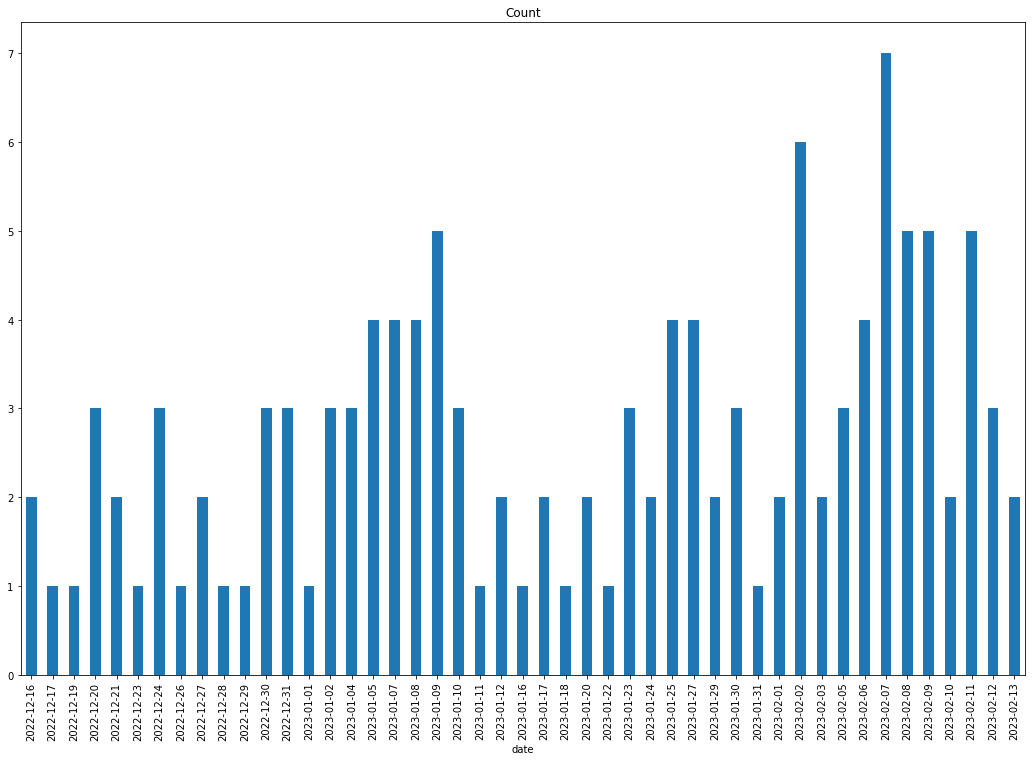

In [14]:
from sklearn.linear_model import Ridge

tweet_df.groupby(by='date').count()['tweet'].plot(kind='bar', figsize=(18,12))
plt.title('Count')
plt.show()

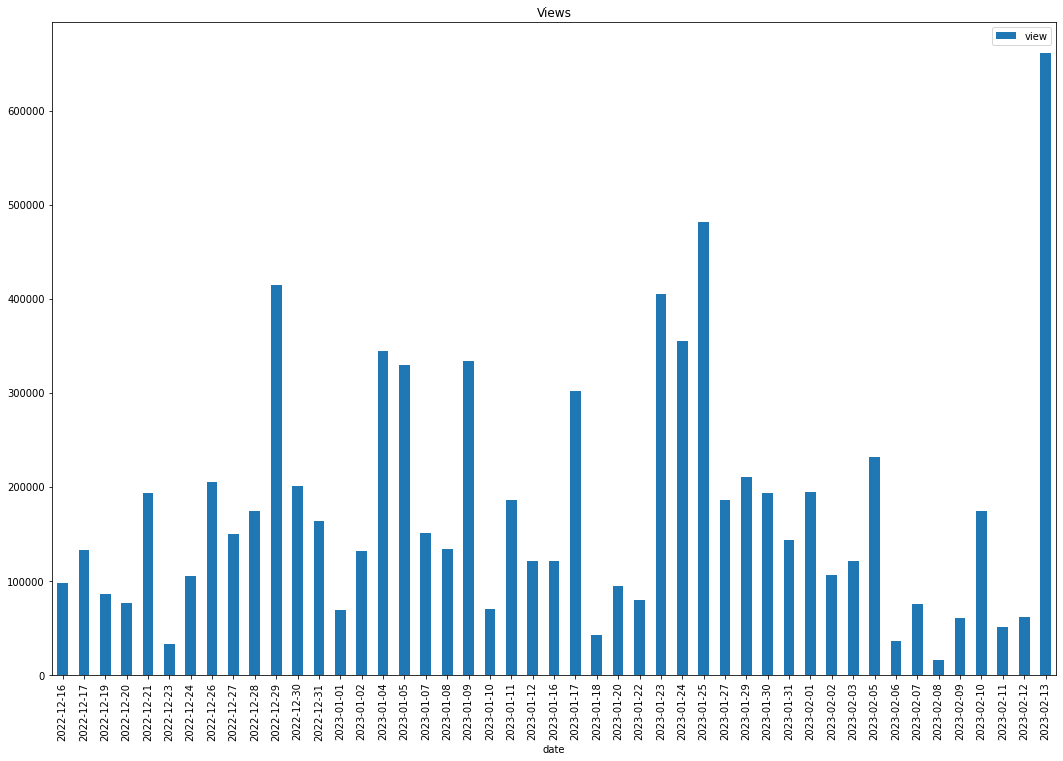

In [15]:
trend_df[['view']].groupby(by='date').mean().plot(kind='bar', figsize=(18,12))
tweet_df.groupby(by='date').count()['tweet'].plot(kind='bar', figsize=(18,12))
plt.title('Views')
plt.show()

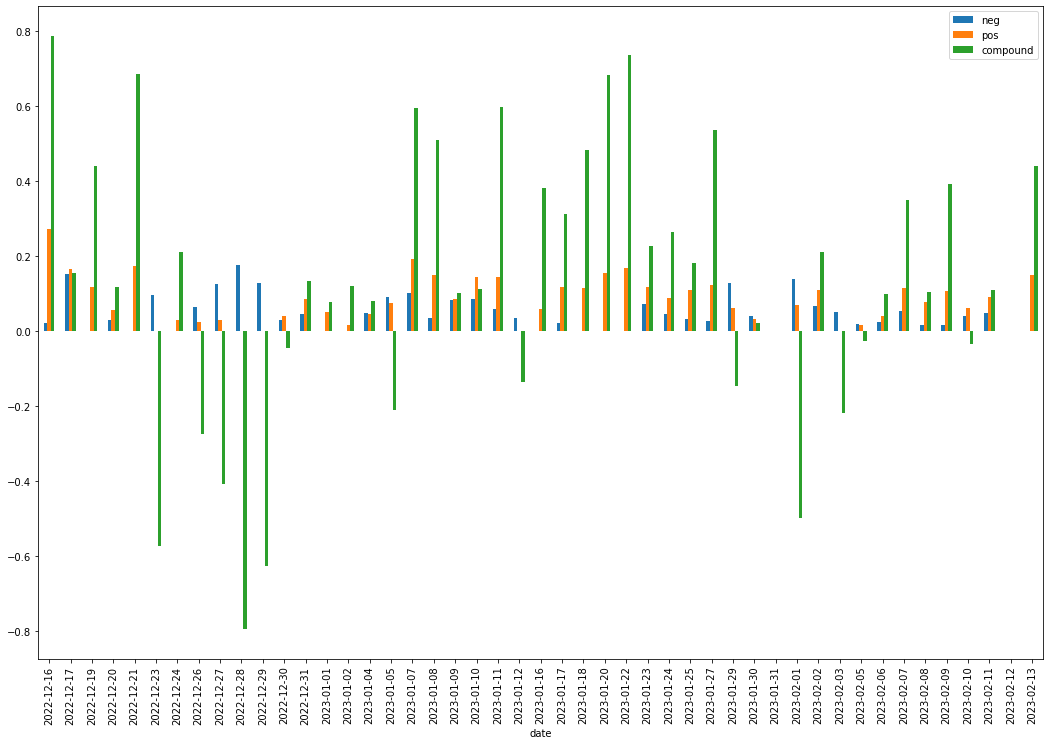

In [16]:
trend_df[['neg', 'pos', 'compound']].groupby(by='date').mean().plot(kind='bar', figsize=(18,12))
plt.show()

In [17]:
import plotly.graph_objects as go

def plot_gauge(search, value, reference=-1):
  fig = go.Figure(go.Indicator(
      domain = {'x': [0, 1], 'y': [0, 1]},
      value = value,
      mode = "gauge+number+delta",
      title = {'text': "{} FEAR & GREED".format(search)},
      delta = {'reference': reference} if reference != -1 else {'reference': value},
      gauge = {'axis': {'range': [None, 100]},
              'bar': {'color': "lightblue", 'thickness':0.3},
              'steps' : [
                  {'range': [75, 100], 'color': "#79fc74"},
                  {'range': [55, 75], 'color': "#a2fac8"},
                  {'range': [45, 55], 'color': "#f9fa9d"},
                  {'range': [25, 45], 'color': "#ffcf87"},
                  {'range': [0, 25], 'color': "#ff8e8a"}],
              }))

  fig.show()

In [18]:
# Montly

plot_gauge('Montly\n' + search, 
           tweet_df[tweet_df['date'] >= (today - relativedelta(months=1)).date()]['compound'].mean() * 100 + 50, 
           tweet_df[(tweet_df['date'] < (today - relativedelta(months=1)).date()) & (tweet_df['date'] >= (today - relativedelta(months=2)).date())]['compound'].mean() * 100 + 50)

In [19]:
# Weekly

plot_gauge(search, 
           tweet_df[tweet_df['date'] >= (today - relativedelta(weeks=1)).date()]['compound'].mean() * 100 + 50, 
           tweet_df[(tweet_df['date'] < (today - relativedelta(weeks=1)).date()) & (tweet_df['date'] >= (today - relativedelta(weeks=2)).date())]['compound'].mean() * 100 + 50)

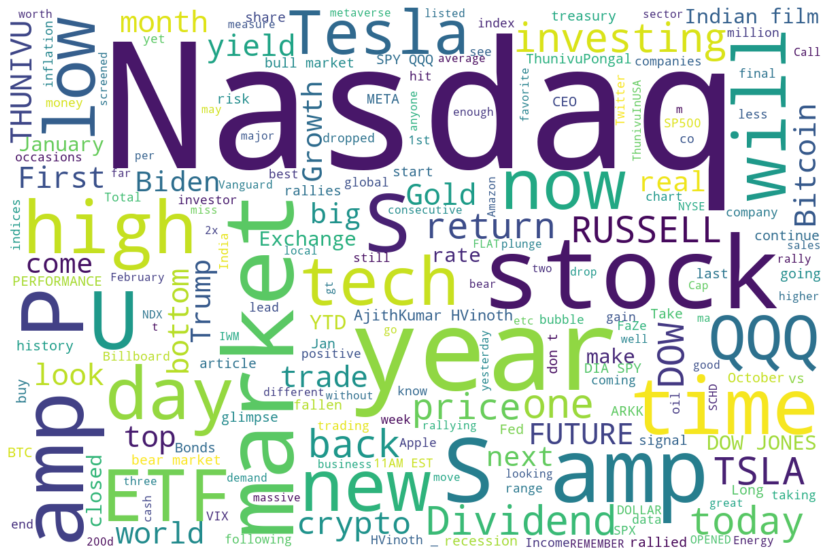

In [20]:
# WordCloud

all_words = ' '.join([x for x in tweet_df['tweet']])
stop_words = ['amp']
word_cloud = WordCloud(width=1200, height=800, background_color='white', stopwords=stop_words).generate(all_words)

plt.figure(figsize=(18,10))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [21]:
from sklearn.preprocessing import normalize

scatter_df = tweet_df.sample(n=100)
norm_view = normalize([scatter_df['view'].values], norm="max")[0]
norm_like = normalize([scatter_df['like'].values], norm="max")[0]

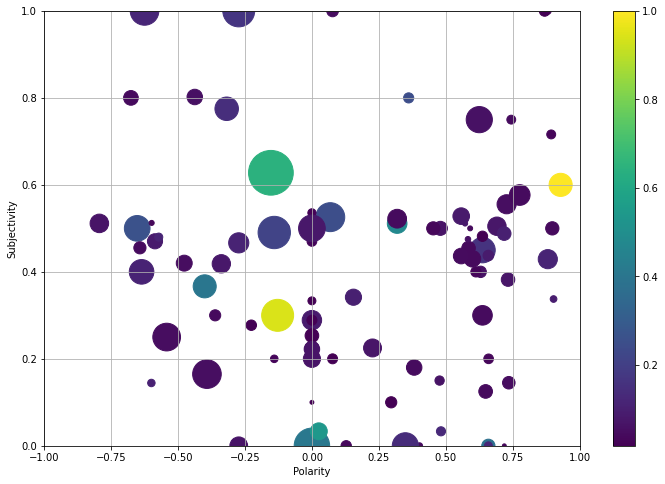

In [22]:
plt.figure(figsize=(12,8))
plt.scatter(scatter_df.iloc[:]['compound'], scatter_df.iloc[:]['subjectivity'], s=norm_view[:]*2000, c=norm_like[:])
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.xlim(-1, 1)
plt.ylim(0, 1)
plt.colorbar()
plt.grid()
plt.show()

In [23]:
import os
import json
import openai

In [24]:
#Stored OpenAPI key in a json file

OPENAI_API_KEY = ''
with open('/content/OpenAI.json', 'r') as file_to_read:
    json_data = json.load(file_to_read)
    OPENAI_API_KEY = json_data["OPENAI_API_KEY"]

openai.api_key =  OPENAI_API_KEY

In [25]:
i =1
tweet_str=''
for tweet in tweet_df.sort_values('view', ascending=False).head()['tweet']:
   tweet_str = tweet_str + str(i) +'.'+'"'+tweet+'"'+'\n'
   i=i+1
   if i == 30:
     break

In [26]:
prompt="Classify the sentiment in these tweets with probability:\n" + tweet_str + "\n Tweet sentiment ratings:"

In [27]:
print(prompt)

Classify the sentiment in these tweets with probability:
1."“So if our $faze stock stays below 1 dollar for 30 days we get kicked off Nasdaq.   But don’t worry I’m the league leader in T-shirt sales”. "
2."Facebook parent company Meta Platforms intends to switch its Nasdaq ticker symbol back to FB on June 9, retiring the META symbol it switched to a year ago, apparently."
3."FTX is not the end of the road for crypto. Its collapse is far more emblematic of issues that crypto addresses than those it introduces. The demand for systems where trust lies in code rather than humans is clear: nasdaq.com/articles/defi-… //  _org"
4."Not only is the Nasdaq 100 heavy with FAANG but it added another $FANG, Diamondback Energy, when it rebalanced in December. Meanwhile, the oil price has been cut nearly in half since March. According to our research, electric mobility will continue to destroy oil demand."
5."Fed minutes summary

“Don’t f**k around with us by pushing ARKK, sh*tcoins and Nasdaq to the

In [28]:
response = openai.Completion.create(
  model="text-davinci-003",
  prompt= prompt,
  temperature=0,
  max_tokens=120,
  top_p=1.0,
  frequency_penalty=0.0,
  presence_penalty=0.0
)

In [29]:
(response["choices"][0]["text"]).split('\n')[1:]

['1.Negative, 0.8',
 '2.Neutral, 0.9',
 '3.Positive, 0.7',
 '4.Neutral, 0.9',
 '5.Negative, 0.8']